# Detección de spam con Machine Learning (ML)

Este cuaderno demuestra el proceso de construcción y evaluación de múltiples modelos de aprendizaje automático para la detección de spam. El conjunto de datos se preprocesa, se vectoriza y luego se utiliza para entrenar y evaluar diferentes modelos de ML. Finalmente, se realiza la optimización de hiperparámetros al modelo que mejor resultado ha obtenido.

---

## 1. Importación de librerías

Comenzamos importando las librerías necesarias de Python para el procesamiento de datos, entrenamiento de modelos y evaluación.

In [3]:
import tratarDatosSimple
import tratarDatos
import os
import itertools
import numpy as np
from matplotlib import pyplot as plt
from sklearn import metrics, tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC

---

## 2. Carga y preprocesamiento de datos

El conjunto de datos se carga y se divide en conjuntos de entrenamiento y prueba utilizando el módulo `tratarDatos`. Este paso asegura que los datos estén listos para la vectorización y el entrenamiento del modelo.

In [4]:
# Cargar y dividir el conjunto de datos
xtrain, xtest, ytrain, ytest = tratarDatos.combinar_y_dividir_datos()
#xtrain, xtest, ytrain, ytest = tratarDatosSimple.combinar_y_dividir_datos()

---

## 3. Vectorización de los datos del texto

Los datos de texto deben convertirse en formato numérico para que los modelos de aprendizaje automático puedan procesarlos. Utilizamos el **Vectorizador TF-IDF** para transformar los datos de texto en características numéricas.

In [5]:
def tfid_vec(train, test):
    # Inicializar el Vectorizador TF-IDF con n-gramas (1 a 2) y una frecuencia mínima de documento de 5
    transformador = TfidfVectorizer(ngram_range=(1, 2), min_df=5)

    # Transformar los datos de entrenamiento y prueba
    train_tfid = transformador.fit_transform(train)
    test_tfid = transformador.transform(test)

    return train_tfid, test_tfid

# Aplicar la vectorización TF-IDF
xtrain_tfid, xtest_tfid = tfid_vec(xtrain, xtest)

---

## 4. Entrenamiento de los modelos de aprendizaje automático

Entrenamos ocho modelos diferentes:
1. **Naive Bayes Multinomial**
2. **K-Vecinos Más Cercanos**
3. **Árbol de Decisión**
4. **Bosque Aleatorio**
5. **Regresión Logística**
6. **Clasificador SGD**
7. **Clasificador AdaBoost**
8. **Clasificador SVM**

In [6]:
# Naive Bayes Multinomial
modeloNB = MultinomialNB().fit(xtrain_tfid, ytrain)

# K-Vecinos Más Cercanos
modeloKNN = KNeighborsClassifier().fit(xtrain_tfid, ytrain)

# Árbol de Decisión
modeloDT = tree.DecisionTreeClassifier().fit(xtrain_tfid, ytrain)

# Bosque Aleatorio
modeloRF = RandomForestClassifier().fit(xtrain_tfid, ytrain)

# Regresión Logística
modeloLR = LogisticRegression().fit(xtrain_tfid, ytrain)

# Clasificador SGD
modeloSGD = SGDClassifier(loss='log_loss').fit(xtrain_tfid, ytrain)

# Clasificador AdaBoost
modeloAdaBoost = AdaBoostClassifier().fit(xtrain_tfid, ytrain)

# Clasificador SVM
modeloSVC = SVC(probability=True).fit(xtrain_tfid, ytrain)

---

## 5. Evaluación de modelos

Evaluamos cada modelo utilizando:
- **Matriz de Confusión**
- **Puntuación de Precisión**
- **Reporte de Clasificación**
- **Curva ROC**

In [17]:
# Crear la carpeta resultados/ML si no existe
os.makedirs("resultados/ML", exist_ok=True)

def dibujar_matriz(ytest, ypreds, classes, nombre_modelo):
    # Graficar la matriz de confusión
    cm = metrics.confusion_matrix(ytest, ypreds, labels=[1, 0])
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(nombre_modelo)
    plt.colorbar()
    ticks = np.arange(len(classes))
    plt.xticks(ticks, classes, rotation=45)
    plt.yticks(ticks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('Etiqueta Verdadera')
    plt.xlabel('Etiqueta Predicha')
    plt.tight_layout()

    # Guardar la imagen de la matriz de confusión
    fichero = f"resultados/ML/{nombre_modelo}_confusion_matrix.png"
    plt.savefig(fichero)

def evaluar_modelo(modelo, xtest, ytest):
    # Obtener predicciones y probabilidades
    ypreds = modelo.predict(xtest)
    yprobs = modelo.predict_proba(xtest)[:, 1]

    # Nombre del modelo
    nombre_modelo = type(modelo).__name__

    print(f'\n--------- {nombre_modelo} ---------\n')

    # Puntuación de precisión
    puntuacion = metrics.accuracy_score(ytest, ypreds)
    print(f'Puntuación de precisión: {puntuacion:.4f}')

    # Matriz de confusión
    classes = ['spam', 'ham']
    plt.figure()
    dibujar_matriz(ytest, ypreds, classes, nombre_modelo)

    # Reporte de clasificación
    print(metrics.classification_report(ytest, ypreds, target_names=['Spam', 'Ham']))

    # Curva ROC
    fpr, tpr, thresholds = metrics.roc_curve(ytest, yprobs)
    roc_auc = metrics.roc_auc_score(ytest, yprobs)

    plt.figure()
    plt.plot(fpr, tpr, label=f'Curva ROC (área = {roc_auc:.3f})')
    plt.legend(loc="best")
    plt.plot([0, 1], [0, 1], 'k--')  # Curva de predicciones aleatorias
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('Tasa de Falsos Positivos')
    plt.ylabel('Tasa de Verdaderos Positivos')
    plt.title(f'ROC {nombre_modelo}')

    # Guardar la imagen de la curva ROC
    fichero = f"resultados/ML/{nombre_modelo}_roc_curve.png"
    plt.savefig(fichero)
    

    return puntuacion, nombre_modelo


--------- MultinomialNB ---------

Puntuación de precisión: 0.9621
              precision    recall  f1-score   support

        Spam       0.96      0.98      0.97      8872
         Ham       0.97      0.94      0.95      6641

    accuracy                           0.96     15513
   macro avg       0.96      0.96      0.96     15513
weighted avg       0.96      0.96      0.96     15513



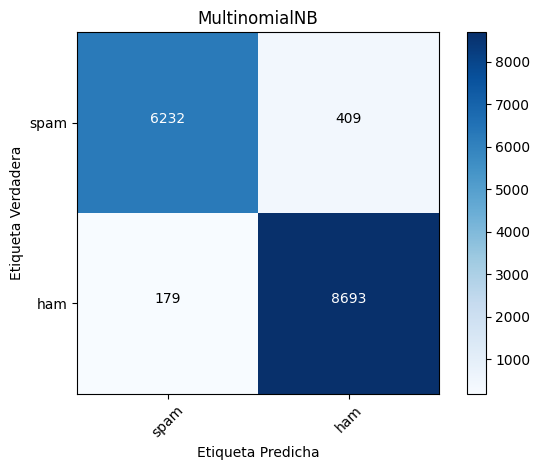

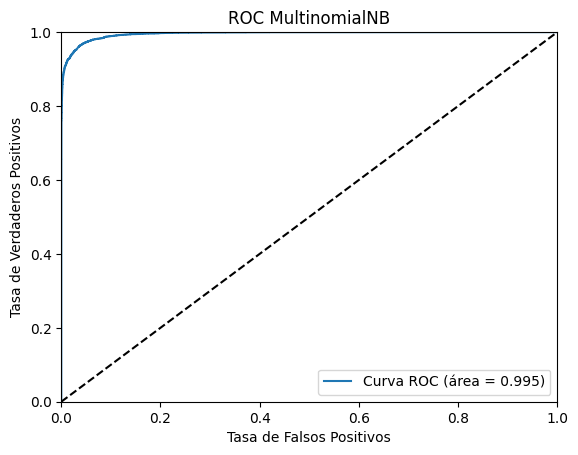

In [18]:
# Evaluar todos los modelos
resultados = []

# Naive Bayes Multinomial
puntuacion, nombre_modelo = evaluar_modelo(modeloNB, xtest_tfid, ytest)
resultados.append((nombre_modelo, puntuacion))


--------- KNeighborsClassifier ---------

Puntuación de precisión: 0.6615
              precision    recall  f1-score   support

        Spam       0.75      0.61      0.67      8872
         Ham       0.58      0.73      0.65      6641

    accuracy                           0.66     15513
   macro avg       0.67      0.67      0.66     15513
weighted avg       0.68      0.66      0.66     15513



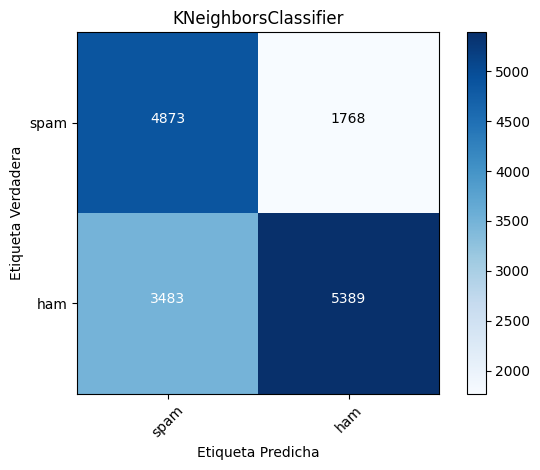

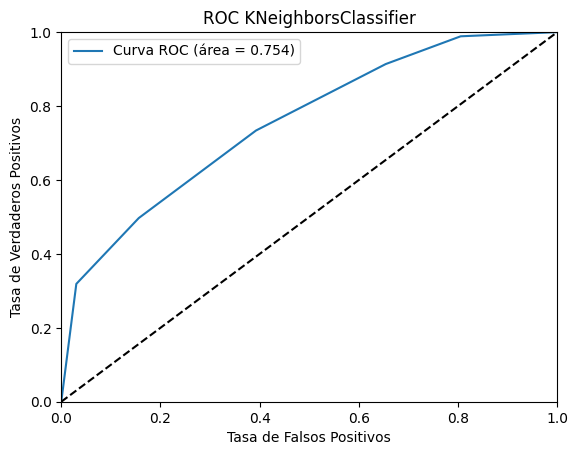

In [19]:
# K-Vecinos Más Cercanos
puntuacion, nombre_modelo = evaluar_modelo(modeloKNN, xtest_tfid, ytest)
resultados.append((nombre_modelo, puntuacion))


--------- DecisionTreeClassifier ---------

Puntuación de precisión: 0.9174
              precision    recall  f1-score   support

        Spam       0.94      0.92      0.93      8872
         Ham       0.89      0.92      0.90      6641

    accuracy                           0.92     15513
   macro avg       0.91      0.92      0.92     15513
weighted avg       0.92      0.92      0.92     15513



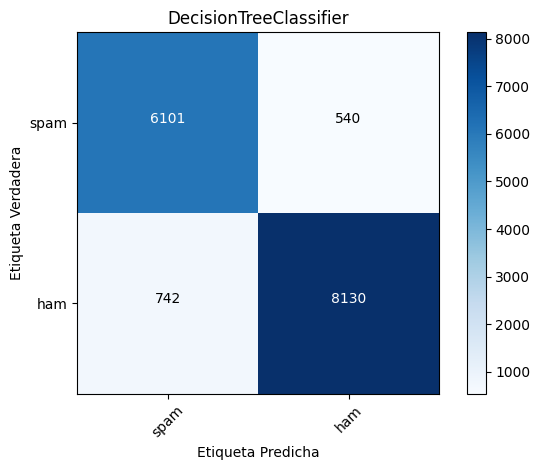

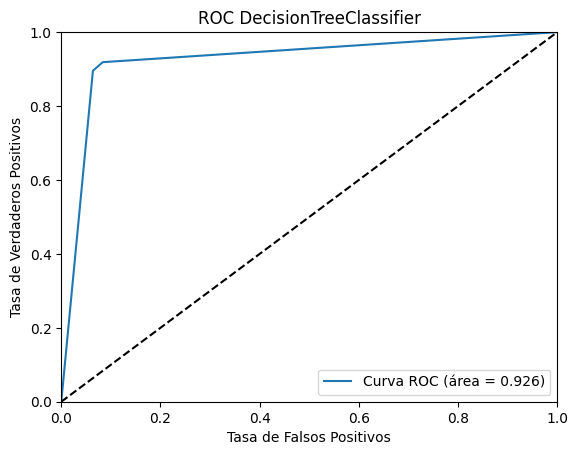

In [20]:
# Árbol de Decisión
puntuacion, nombre_modelo = evaluar_modelo(modeloDT, xtest_tfid, ytest)
resultados.append((nombre_modelo, puntuacion))


--------- RandomForestClassifier ---------

Puntuación de precisión: 0.9640
              precision    recall  f1-score   support

        Spam       0.96      0.98      0.97      8872
         Ham       0.98      0.94      0.96      6641

    accuracy                           0.96     15513
   macro avg       0.97      0.96      0.96     15513
weighted avg       0.96      0.96      0.96     15513



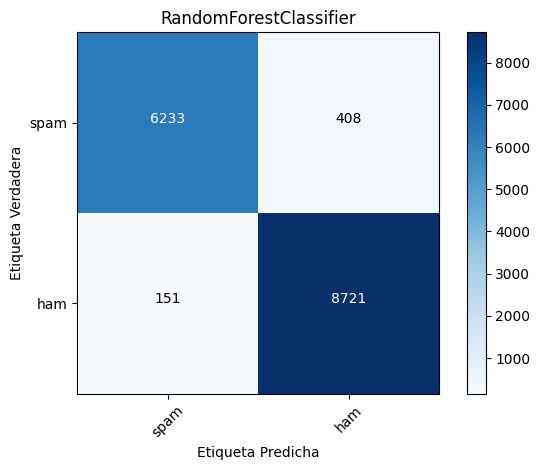

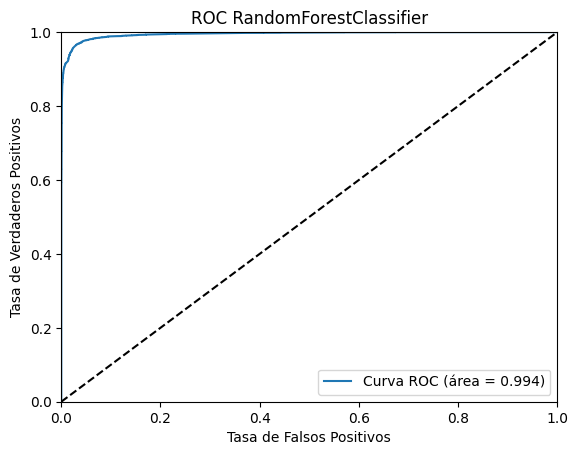

In [21]:
# Bosque Aleatorio
puntuacion, nombre_modelo = evaluar_modelo(modeloRF, xtest_tfid, ytest)
resultados.append((nombre_modelo, puntuacion))


--------- LogisticRegression ---------

Puntuación de precisión: 0.9660
              precision    recall  f1-score   support

        Spam       0.96      0.98      0.97      8872
         Ham       0.97      0.95      0.96      6641

    accuracy                           0.97     15513
   macro avg       0.97      0.96      0.97     15513
weighted avg       0.97      0.97      0.97     15513



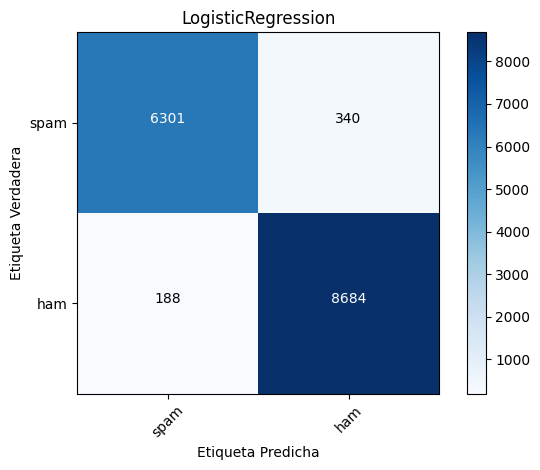

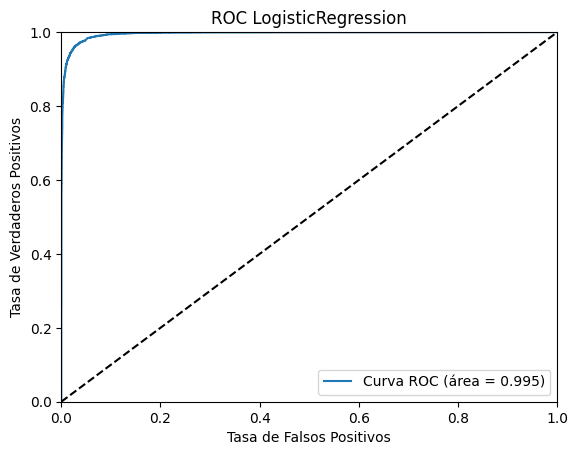

In [22]:
# Regresión Logística
puntuacion, nombre_modelo = evaluar_modelo(modeloLR, xtest_tfid, ytest)
resultados.append((nombre_modelo, puntuacion))


--------- SGDClassifier ---------

Puntuación de precisión: 0.9575
              precision    recall  f1-score   support

        Spam       0.95      0.98      0.96      8872
         Ham       0.97      0.93      0.95      6641

    accuracy                           0.96     15513
   macro avg       0.96      0.95      0.96     15513
weighted avg       0.96      0.96      0.96     15513



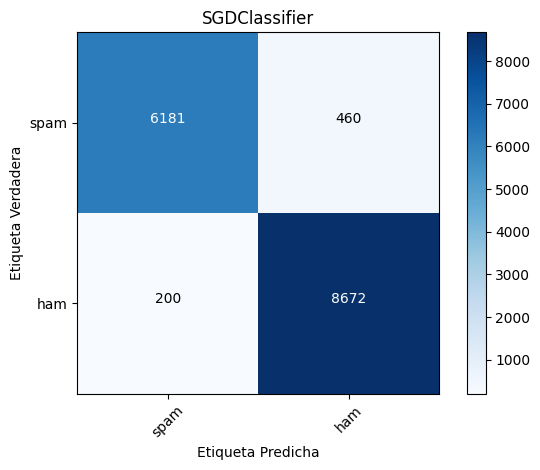

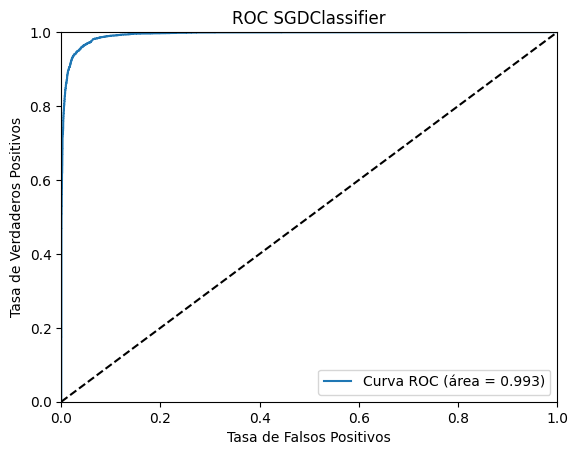

In [23]:
# Clasificador SGD
puntuacion, nombre_modelo = evaluar_modelo(modeloSGD, xtest_tfid, ytest)
resultados.append((nombre_modelo, puntuacion))


--------- AdaBoostClassifier ---------

Puntuación de precisión: 0.8423
              precision    recall  f1-score   support

        Spam       0.81      0.94      0.87      8872
         Ham       0.90      0.71      0.79      6641

    accuracy                           0.84     15513
   macro avg       0.86      0.83      0.83     15513
weighted avg       0.85      0.84      0.84     15513



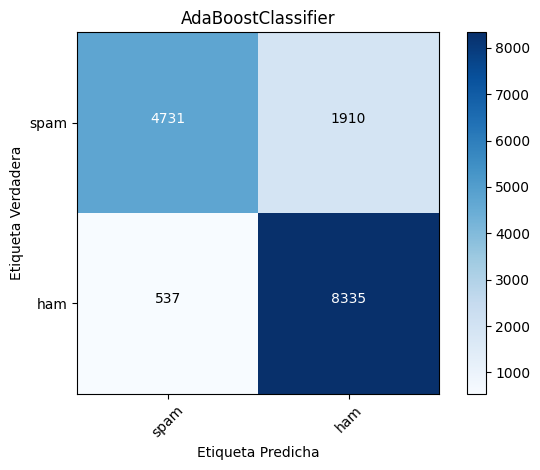

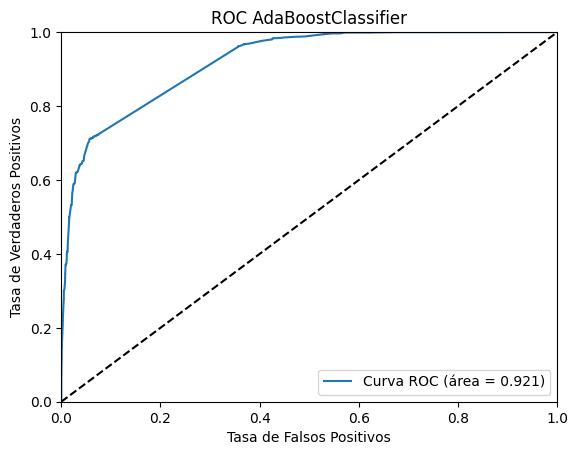

In [24]:
# Clasificador AdaBoost
puntuacion, nombre_modelo = evaluar_modelo(modeloAdaBoost, xtest_tfid, ytest)
resultados.append((nombre_modelo, puntuacion))


--------- SVC ---------

Puntuación de precisión: 0.9739
              precision    recall  f1-score   support

        Spam       0.97      0.98      0.98      8872
         Ham       0.98      0.96      0.97      6641

    accuracy                           0.97     15513
   macro avg       0.97      0.97      0.97     15513
weighted avg       0.97      0.97      0.97     15513



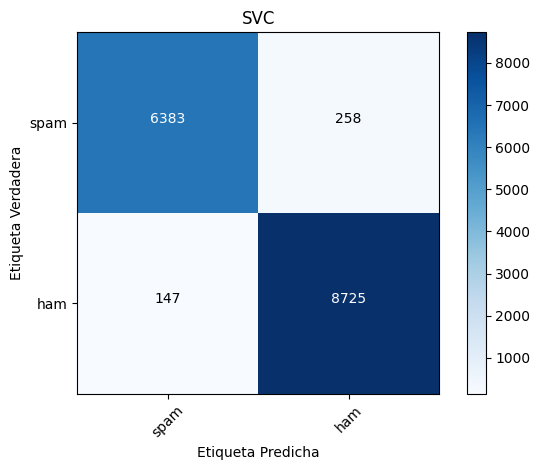

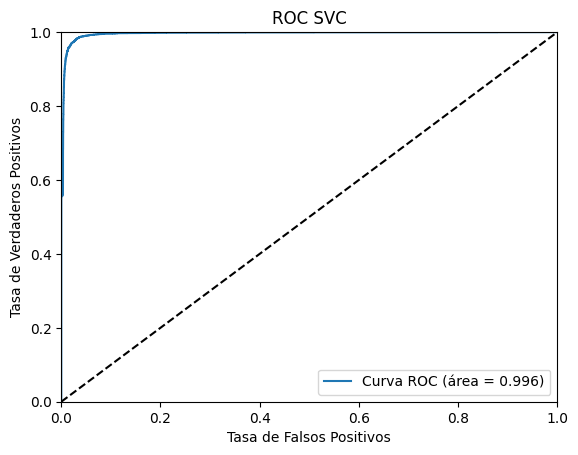

In [25]:
# Clasificador SVM
puntuacion, nombre_modelo = evaluar_modelo(modeloSVC, xtest_tfid, ytest)
resultados.append((nombre_modelo, puntuacion))

In [27]:
# Imprimir resultados
for nombre, puntuacion in resultados:
    print(f'{nombre}: {puntuacion:.4f}')

MultinomialNB: 0.9621
KNeighborsClassifier: 0.6615
DecisionTreeClassifier: 0.9174
RandomForestClassifier: 0.9640
LogisticRegression: 0.9660
SGDClassifier: 0.9575
AdaBoostClassifier: 0.8423
SVC: 0.9739


---

## 6. Optimización de hiperparámetros para el mejor modelo

Utilizamos **GridSearchCV** para encontrar los mejores hiperparámetros para el clasificador SVC.

In [ ]:
# Define hyperparameters for grid search
grid_params = {
    "C": [0.01, 0.1, 1, 10, 100],  # Regularization parameter
    "kernel": ["linear", "rbf", "poly"],  # Kernel type
    "gamma": ["scale", "auto"] + [0.001, 0.01, 0.1, 1],  # Kernel coefficient
}
svc_model = SVC(probability=True)  # Enable probability for ROC curve

# Perform grid search
mymodelSVC_Grid = GridSearchCV(svc_model, param_grid=grid_params, cv=5, n_jobs=-1)
mymodelSVC_Grid.fit(xtrain_tfid, ytrain)

# Print best parameters and accuracy
print("Best hyperparameters:", mymodelSVC_Grid.best_params_)
print("Accuracy:", mymodelSVC_Grid.best_score_)

# Evaluate the best model
best_SVC = mymodelSVC_Grid.best_estimator_
puntuacion, nombre_modelo = evaluar_modelo(best_SVC, xtest_tfid, ytest)